In [1]:
import os
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import ipywidgets as widgets
from IPython.display import Image, display

import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


In [2]:
''' 
Define style specifying text details to save manual plot editing
General Ref: https://matplotlib.org/3.3.2/tutorials/introductory/customizing.html
'''
sns.set_theme(style = 'darkgrid', 
              rc = {'figure.titlesize' : 22, 
                    'figure.titleweight' : 'bold',
                    'axes.titleweight' : 'bold',
                    'axes.titlesize' : 22, 
                    'axes.labelweight' : 'bold',
                    'axes.labelsize' : 18,
                    'xtick.labelsize' : 14,
                    'ytick.labelsize' : 14
                   }
             )

# Data Import

Due to the unlabeled nature of the provided dataset, I opt to use the train and test names in place of more informative names. The absence of missing values enables me to focus on EDA directly related to model building and skip questions about imputation methods.

I create a smaller training set for visualization to dramatically reduce computation time.

In [3]:
train = pd.read_csv('./data/train.csv', index_col='id')

print('{:,} training observations'.format(train.shape[0]))
print('{} features'.format(train.shape[1] - 1))
print('{} missing values'.format(train.isnull().sum().sum()))
print('')
test = pd.read_csv('./data/test.csv', index_col='id')

print('{:,} test observations'.format(test.shape[0]))
print('{} missing values'.format(test.isnull().sum().sum()))


train_sub = train.sample(frac = 0.05, axis = 0, random_state = 42)
test_sub = test.sample(frac = 0.05, axis = 0, random_state = 42)

300,000 training observations
14 features
0 missing values

200,000 test observations
0 missing values


# EDA of Target

              target
count  300000.000000
mean        7.905661
std         0.733071
min         0.000000
25%         7.329367
50%         7.940571
75%         8.470084
max        10.267569


''

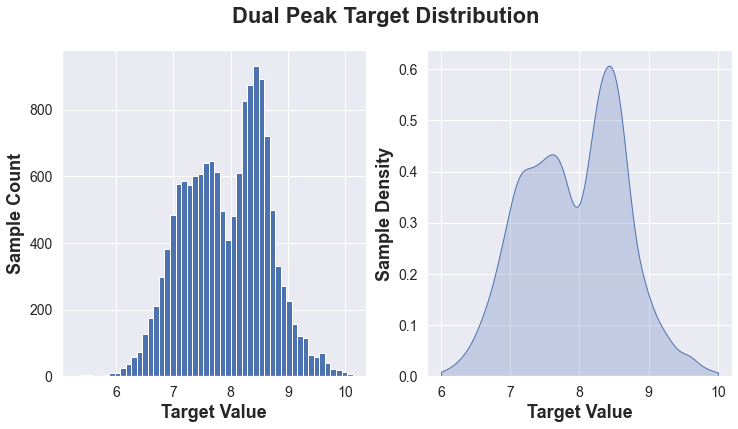

In [4]:
print(train[['target']].describe())

plt.figure(figsize=(12,6))
ax1 = plt.subplot(1, 2, 1)
plt.hist(train_sub['target'], bins = 50)
plt.xlabel('Target Value')
plt.ylabel('Sample Count')

ax2 = plt.subplot(1, 2, 2)
sns.kdeplot(train_sub['target'], shade=True, clip = [6, 10])
plt.ylabel('Sample Density')
plt.xlabel('Target Value')

plt.suptitle('Dual Peak Target Distribution')
;

The target feature displays a multimodal distribution with peaks at around 7.5 and 8.5 and a drop in frequency near 8. This may highly impact our ability to accuractely predict the target. Because models predict the average y, any predictions near 8 will inflate the error due to the inability to identify which peak an observation belongs to.

One possible approach to experiment with would be to categorize observations into being in the lower or upper peak and building distinct models for the two groups. This is because the the density plot implies the possibility of a categorical variable missing from the dataset which distinguisheses two overlapping curves.

### Possibly Two Distinct Generators

''

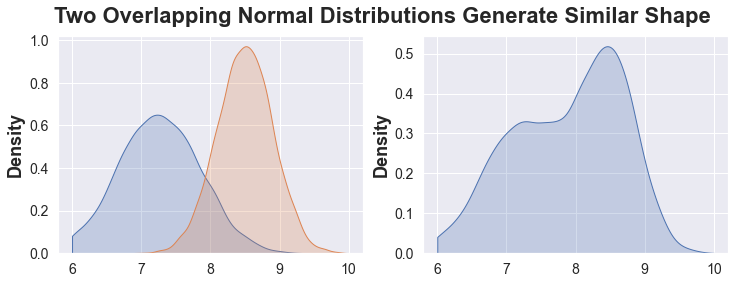

In [5]:
norm1 = np.random.normal(7.25, 0.6, 10000)
norm2 = np.random.normal(8.5, 0.4, 10000)
norm_all = np.concatenate((norm1, norm2))

f, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
sns.kdeplot(norm1, shade=True, clip = [6, 10], ax = axes[0])
sns.kdeplot(norm2, shade=True, clip = [6, 10], ax = axes[0])
sns.kdeplot(norm_all, shade=True, clip = [6, 10], ax = axes[1])
plt.suptitle('Two Overlapping Normal Distributions Generate Similar Shape')

;

While less pronounced than the provided data, this plot illustrates how two overlapping distributions of reasonable shape can generate the observed bimodal distribution. This motivates the pursuit of trying to proxy the potential missing category variable.

# Overview of Provided Features

In [6]:
features = train.columns.drop('target')

train[features].describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.506873,0.497898,0.521557,0.515683,0.502022,0.526515,0.487890,0.525163,0.459857,0.520532,0.483926,0.506877,0.553442,0.503713
std,0.203976,0.228159,0.200770,0.233035,0.220701,0.217909,0.181096,0.216221,0.196685,0.201854,0.220082,0.218947,0.229730,0.208238
min,-0.082263,-0.031397,0.020967,0.152761,0.276377,0.066166,-0.097666,0.217260,-0.240604,-0.085046,0.083277,0.088635,0.029950,0.166367
25%,0.343078,0.319170,0.344096,0.294935,0.284108,0.356163,0.346600,0.341486,0.330832,0.375465,0.300474,0.310166,0.350472,0.308673
50%,0.484005,0.553209,0.551471,0.482880,0.451733,0.470988,0.466825,0.483460,0.416843,0.458877,0.441916,0.486599,0.487707,0.431845
75%,0.643789,0.731263,0.648315,0.748705,0.670660,0.694043,0.581292,0.685250,0.575041,0.700292,0.679128,0.694453,0.768479,0.712653
max,1.016227,0.859697,1.006955,1.010402,1.034261,1.043858,1.066167,1.024427,1.004114,1.199951,1.022620,1.049025,0.977845,0.868506


All 14 provided features exhibit a support of about [0,1] with a mean and median within 0.45 to 0.55. 

''

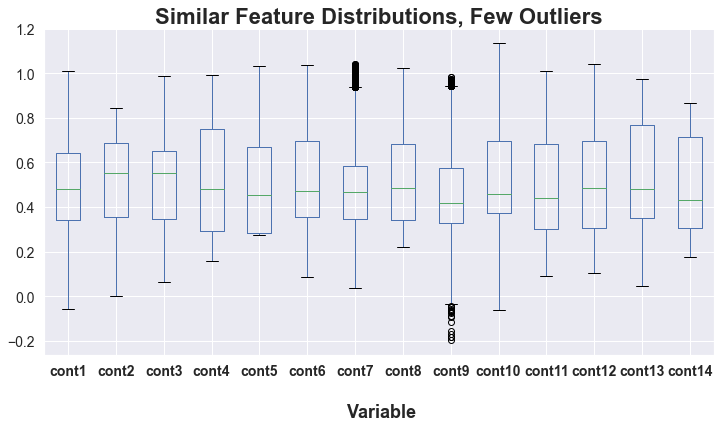

In [7]:
plt.figure(figsize = (12, 6))
train_sub[features].boxplot()

plt.xticks(fontweight = 'bold')
plt.xlabel('\n Variable')
plt.title('Similar Feature Distributions, Few Outliers')
;

The above boxplots visualization the description statistics above. Many of these variables display relatively high variance and have been pre-standardized onto a comparable scale. While not perfectly scaled as with applying StandardScaler, the gains from scaling may be non-existent because these variables already lie on comparable supports and thus are directly comparable in a gradient optimization.

Variables 7 and 9 display the narrowest IQR and the only outliers. I will have to explore if these outliers impact the performance of any models I build. Dropping outliers is typically a reasonable option but we do not want to drop these if the test set has values near this extreme.

''

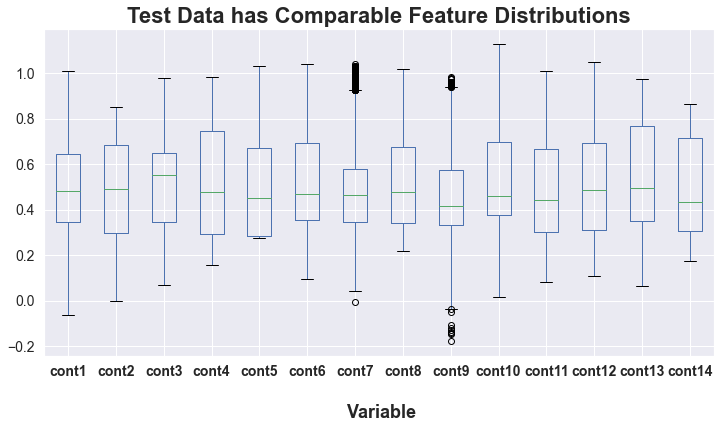

In [8]:
plt.figure(figsize = (12, 6))
test_sub[features].boxplot()

plt.xticks(fontweight = 'bold')
plt.xlabel('\n Variable')
plt.title('Test Data has Comparable Feature Distributions')
;

These boxplots reveal an overall similarity between the feature value ranges in train and test sets. Because we observe outliers in cont7 and cont9 variables in the test set, we know that extreme observations are inherent to these features and should be cautious about eliminating outliers prior to model fitting since doing so may increase the errors predicting the target on these values.

### Target Correlation

''

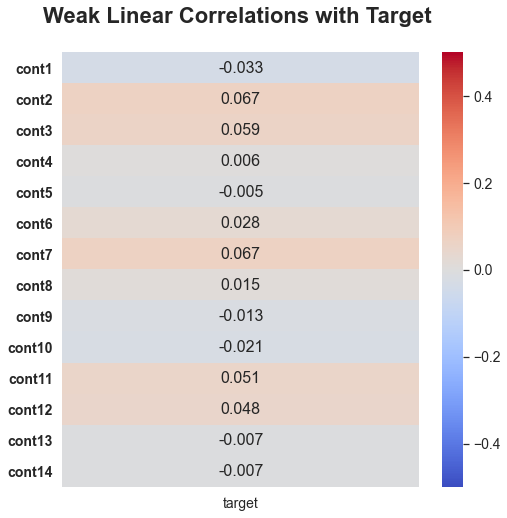

In [9]:
plt.figure(figsize = (8, 8))
sns.heatmap(train.corr()[['target']].drop('target'),
            annot = True,
            cmap = 'coolwarm',
            vmin = -0.5, 
            vmax = 0.5,
            fmt = '.3f', 
            annot_kws = {'fontsize' : 16})
plt.yticks(fontweight = 'bold', rotation = 0)
plt.title('Weak Linear Correlations with Target \n')
;

None of the provided features display a strong correlation with the target value. This suggests these features either
- Exhibit a non-linear relationship with the target which must be identified
- Exhibit a weak relationship independent of other features but the conditional influence may be stronger 

Further EDA of these relationships is required to identify the cause.

### Pairwise Correlations

''

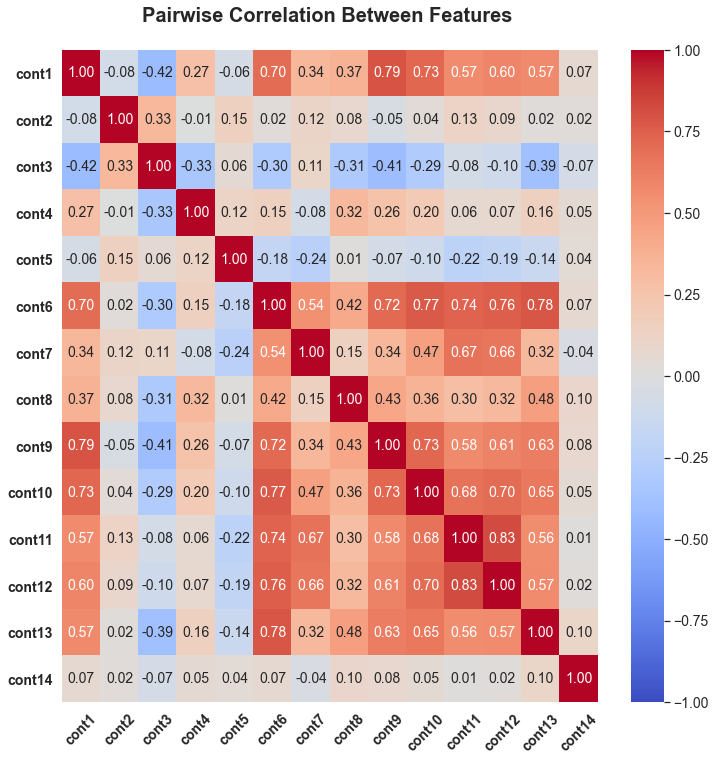

In [10]:
corr_matrix = train.drop(columns = ['target']).corr()

plt.figure(figsize = (12, 12))
sns.heatmap(corr_matrix,
            annot = True,
            cmap = 'coolwarm',
            vmin = -1, 
            vmax = 1,
            fmt = '.2f',
            annot_kws = {'fontsize' : 14})
plt.yticks(fontweight = 'bold', rotation = 0)
plt.xticks(fontweight = 'bold', rotation = 45)
plt.title('Pairwise Correlation Between Features \n', fontsize = 20, fontweight = 'bold')
;

Features 1 and 6 through 13 display a strong collinearity in the above heatmap. Within these 9 features, many pairwise correlations surpass 0.5 and all are noticably stronger than values outside of these. A L2 norm will likely improve any linear model built as a pure OLS model will suffer from high variance due to this collinearity.

## EDA of Individual Features

### Univariate Historgrams and Scatterplots with Targets

In [11]:
def vis_feat(var, df = train_sub):
    '''
    Signature:
    vis_feat(var, df = train)
    
    Docstring:
    Display side-by-side plots of specified variable from dataframe. 
    Left plot is density histogram of specified feature. 
    Right plot is scatterplot with target variable.
    '''

    fig = plt.figure(figsize = (12,6))

    ax1 = plt.subplot(121)
    ax1.hist(df[var], bins = 20, density = True)
    plt.xlabel(f"{var}")
    plt.ylabel('Density')

    ax2 = plt.subplot(122)
    ax2.scatter(df[var], df['target'], alpha=0.25)
    plt.xlabel(f"{var}")
    plt.ylabel('Target Value')

    plt.suptitle('{} Feature Distribution'.format(var.title()), fontsize = 22, fontweight = 'bold')

    return fig

In [12]:
%%capture 
# Surpress plots from displaying within notebook

dist_dir = './figures/feat_dist'
if not os.path.isdir(dist_dir): # Delete subdirectory to regenerate images
    os.mkdir(dist_dir)
    for feat in features: 
        fig = vis_feat(feat)
        figurl = dist_dir + '/' + feat + '_plot'
        fig.savefig(figurl)

In [13]:
# Widget adapted from burnpanck @ stackoverflow.com/questions/25967522

dist_dir = './figures/feat_dist/'
imgs = list(filter(lambda fn:fn.lower().endswith('.png'), os.listdir(dist_dir)))
imgs.sort()
# Hack to natural sort variable names
dist_imgs = [i for i in imgs if len(i) == 14] + [i for i in imgs if len(i) == 15]

def load_hist_scatter(k):
    '''
    Loading function for use in generating interactive visualization widget
    '''
    display(Image(open(os.path.join(dist_dir,dist_imgs[k-1]),'rb').read()))


widgets.interact(load_hist_scatter ,k=(1,len(dist_imgs)))

interactive(children=(IntSlider(value=7, description='k', max=14, min=1), Output()), _dom_classes=('widget-int…

<function __main__.load_hist_scatter(k)>

Moving through the slideshow above, none of the provided features display a normal distribution of values. The right plot also reveals the low correlation values calculated above result from very high variation of target value and weak relationships to the individual features. No scatterplots reveal any nonlinear relationships with the target.
<br><br>


The plots above generate some important conclusions across features
1. Most features display multiple peaks in density plots
2. Features with a more even spread in values tend to display no trend in target
3. Features with distinct dense value regions display high-variance bands in the scatterplots


Similar Types:
- Relatively broad spread: 6, 7, 8, 11, 12
- Extreme clustering: 1, 2, 9, 14


Specific Notes:
- Cont1: Multiple weakly-separated density peaks, candidate for binning but no trend evident
- Cont2: Multiple isolated value clumps near middle values, strong candidate for binning
- Cont5: Massive concentration around 0.3, fairly even spread above
- Cont6: Heavily skewed right, wide spread, positive kurtosis (semi-skinny)
- Cont7: Heavily skewed right, wide spread, negative kurtosis (fat)
- Cont13: Major clump at 0.3, moderate bands
- Cont14: 6 weakly separated clusters

### Bivariate KDEs with Scatterplots

In [14]:
%%capture 
# Surpress plots from displaying within notebook

pairplot_dir = './figures/feat_pairplots'
if not os.path.isdir(pairplot_dir): # Delete subdirectory to regenerate images
    os.mkdir(pairplot_dir)
    for pair in combinations(features, 2):
        pp_fig = sns.pairplot(train_sub[[pair[0], pair[1]]])
        plt.suptitle('Pairplots')
        plt.subplots_adjust(top = 0.9)
        pp_fig.fig.set_size_inches(6,6)
        
        figurl = pairplot_dir + '/' + pair[0] + '-' + pair[1] + '_plot'
        pp_fig.savefig(figurl)


# WARNING: Density plots take time to complete
pairdensity_dir = './figures/feat_pairdensity'
if not os.path.isdir(pairdensity_dir): 
    os.mkdir(pairdensity_dir)
    for pair in combinations(features, 2):
        jp_fig = sns.jointplot(data = train_sub, x = pair[0], y = pair[1],
                               kind='kde',
                               palette = 'Blues',
                               marginal_kws = {'shade' : True}, 
                               joint_kws = {'shade' : True})
        plt.suptitle('Pairwise Density')
        plt.subplots_adjust(top = 0.9)
        jp_fig.fig.set_size_inches(6,6)
        
        figurl = pairdensity_dir + '/' + pair[0] + '-' + pair[1] + '_plot'
        jp_fig.savefig(figurl)


In [15]:
imgs = list(filter(lambda fn:fn.lower().endswith('.png'), os.listdir(pairplot_dir)))
imgs.sort()
pair_imgs = [i for i in imgs if len(i) == 20] 
pair_imgs += [i for i in imgs if len(i) == 21] 
pair_imgs += [i for i in imgs if len(i) == 22]

imgs = list(filter(lambda fn:fn.lower().endswith('.png'), os.listdir(pairdensity_dir)))
imgs.sort()
dense_imgs = [i for i in imgs if len(i) == 20] 
dense_imgs += [i for i in imgs if len(i) == 21] 
dense_imgs += [i for i in imgs if len(i) == 22]


# Widget adapted from cosmoscalibur @ stackoverflow.com/questions/51315566

def load_pair_density(j, k):
    '''
    Loading function for use in generating interactive visualization widget
    '''
    
    if j == k: #Customer message for when one variable is input twice
        print('Warning: Function not defined for j=k')
        print('Use alternative visualization functions for univariate plots.')
        return
    
    plot_str = 'cont{}-cont{}_plot.png'.format(j, k)
    img1 = open(pairplot_dir + '/' + plot_str, 'rb').read()
    img2 = open(pairdensity_dir + '/' + plot_str, 'rb').read()

    wi1 = widgets.Image(value = img1, format='png', width=400, height=400)
    wi2 = widgets.Image(value = img2, format='png', width=400, height=400)
    sidebyside = widgets.HBox([wi1, wi2])

    display(sidebyside)


widgets.interact(load_pair_density, j=(1,14), k=(1,14))

interactive(children=(IntSlider(value=7, description='j', max=14, min=1), IntSlider(value=7, description='k', …

<function __main__.load_pair_density(j, k)>

Based on the correlation heatmap produced earlier, variables 1, 3, and 6-13 demonstrate the strongest correlation with other features and we can ignore other pairings.

In [16]:
def vis_linear_corr(var, df = train_sub):
    '''
    Signature:
    vis_linear_corr(var, df = train_sub)
    
    Docstring:
    Display regression plots between specified variable and 5 strongest correlated other variables from df.
    '''
    if type(var) == int: # Hack to simplify variable entry when calling function
        var = 'cont' + str(var)
        
    top3_corr = np.abs(corr_matrix[var]).sort_values(ascending = False).index[1:4]
    lin_fig = sns.pairplot(df, x_vars = top3_corr.insert(3, 'target'), y_vars = var,
                           kind = 'reg', diag_kind = None, 
                           plot_kws = { 'line_kws' : {'color' : 'orange'}, 
                                       'scatter_kws' : {'alpha': 0.01}
                                      }
                          )
    return lin_fig


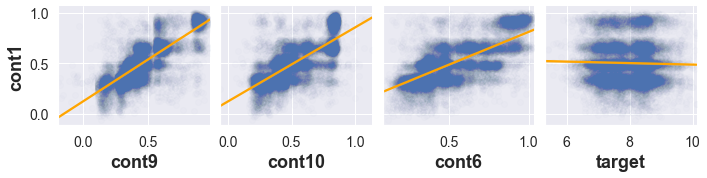

In [17]:
vis_linear_corr('cont1')

### Standardize features to compare performance in future 

In [18]:
train_std = train.copy().drop('target', axis=1)
ss = StandardScaler()
train_std = ss.fit_transform(train_std)
train_std = pd.DataFrame(train_std, index = train.index, columns = train.columns.drop('target'))
train_std['target'] = train['target'].copy()

train_sub_std = train_std.sample(frac = 0.05, axis = 0, random_state = 42)

# EDA of Feature Transformations

In the EDA above, no non-linear relationships between provided features and the target were identified. As such, it is unlikely squaring any feature will improve their predictive power. However, I proceed to verify this presumption below. I also explore features interactions.

In [19]:
train_poly = train.copy().drop('target', axis=1)
poly = PolynomialFeatures(degree = 3, include_bias=False)
train_poly = poly.fit_transform(train_poly)
train_poly = pd.DataFrame(train_poly, index = train.index, columns = poly.get_feature_names(features))
train_poly.columns = train_poly.columns.str.replace(' ', '_')
train_poly['target'] = train['target'].copy()

train_poly_sub = train_poly.sample(frac = 0.05, axis = 0, random_state = 42)

test_poly = test.copy()
test_poly = poly.transform(test_poly)

poly_corr = train_poly.corr()[['target']].drop('target')

power2_features = train_poly.columns[(train_poly.columns.str.contains('\^2') 
                    & ~(train_poly.columns.str.contains('_')))].tolist()
power3_features = train_poly.columns[(train_poly.columns.str.contains('\^3') 
                    & ~(train_poly.columns.str.contains('_')))].tolist()

int1_features = train_poly.columns[(~train_poly.columns.str.contains('\^') 
                    & (train_poly.columns.str.count('_') == 1))].tolist()
int2_features = train_poly.columns[(~train_poly.columns.str.contains('\^') 
                    & (train_poly.columns.str.count('_') == 2))].tolist()


### Univariate Power Transformations

In [20]:
corr_compare = poly_corr.loc[features, :]
corr_compare.columns = ['1st_power']

corr_compare['2nd_power'] = np.array(poly_corr.loc[power2_features,:]) 
corr_compare['3rd_power'] = np.array(poly_corr.loc[power3_features,:])

corr_compare['2v1_pctdiff'] = np.abs(corr_compare['2nd_power']) - np.abs(corr_compare['1st_power'])
corr_compare['2v1_pctdiff'] = corr_compare['2v1_pctdiff'] / np.abs(corr_compare['1st_power']) * 100
corr_compare['3v1_pctdiff'] = np.abs(corr_compare['3rd_power']) - np.abs(corr_compare['1st_power'])
corr_compare['3v1_pctdiff'] = corr_compare['3v1_pctdiff'] / np.abs(corr_compare['1st_power']) * 100
corr_compare['3v2_pctdiff'] = np.abs(corr_compare['3rd_power']) - np.abs(corr_compare['2nd_power'])
corr_compare['3v2_pctdiff'] = corr_compare['3v2_pctdiff'] / np.abs(corr_compare['2nd_power']) * 100


display(round(corr_compare, 2))

print('{} features squared have weaker correlation with target than original feature.'.format(
    (corr_compare['2v1_pctdiff'] < 0).sum()))
print('{} features squared have stronger correlation with target than original feature.'.format(
    (corr_compare['2v1_pctdiff'] > 0).sum()))
print('{} features squared strengthened correlation by 10% or more.'.format(
    (corr_compare['2v1_pctdiff'] > 10).sum()))
print('Maximum correlation to target of original features is {:.4f}'.format(max(corr_compare['1st_power'])))
print('Maximum correlation to target of squared features is {:.4f}'.format(max(corr_compare['2nd_power'])))
print('\n')

print('{} features cubed have weaker correlation with target than original feature.'.format(
    (corr_compare['3v1_pctdiff'] < 0).sum()))
print('{} features cubed have stronger correlation with target than original feature.'.format(
    (corr_compare['3v1_pctdiff'] > 0).sum()))
print('{} features cubed strengthened correlation by 10% or more.'.format(
    (corr_compare['3v1_pctdiff'] > 10).sum()))
print('Maximum correlation to target of original features is {:.4f}'.format(max(corr_compare['1st_power'])))
print('Maximum correlation to target of cubed features is {:.4f}'.format(max(corr_compare['3rd_power'])))


,1st_power,2nd_power,3rd_power,2v1_pctdiff,3v1_pctdiff,3v2_pctdiff
cont1,-0.03,-0.03,-0.02,-19.35,-40.06,-25.68
cont2,0.07,0.06,0.05,-10.34,-20.59,-11.43
cont3,0.06,0.07,0.08,17.72,29.20,9.76
cont4,0.01,0.02,0.02,175.25,308.64,48.46
cont5,-0.01,-0.01,-0.01,35.71,60.77,18.47
cont6,0.03,0.03,0.03,-1.19,0.70,1.91
cont7,0.07,0.06,0.06,-7.12,-16.12,-9.69
cont8,0.01,0.01,0.01,-22.11,-48.43,-33.79
cont9,-0.01,-0.01,-0.01,3.93,-9.78,-13.19
cont10,-0.02,-0.02,-0.02,6.51,10.63,3.87


8 features squared have weaker correlation with target than original feature.
6 features squared have stronger correlation with target than original feature.
3 features squared strengthened correlation by 10% or more.
Maximum correlation to target of original features is 0.0672
Maximum correlation to target of squared features is 0.0694


8 features cubed have weaker correlation with target than original feature.
6 features cubed have stronger correlation with target than original feature.
5 features cubed strengthened correlation by 10% or more.
Maximum correlation to target of original features is 0.0672
Maximum correlation to target of cubed features is 0.0761


Applying square and cubic transforms to the original provided features weakened those features correlation with the target in most cases. This result follows naturally from the EDA above that revealed no apparent functional relationship between the provided features and the target outcome.

#### Visualize Power Transform

In [21]:
def vis_power(var):

    fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, sharey = True, figsize = (12,5))
    sns.regplot(x = var, y = 'target', data = train_poly_sub, fit_reg = True, 
               line_kws = {'color' : 'orange'}, 
               scatter_kws = {'alpha': 0.05}, ax = ax1)
    sns.regplot(x = var + '^2', y ='target', data = train_poly_sub, fit_reg = True,
               line_kws = {'color' : 'orange'}, 
               scatter_kws = {'alpha': 0.05}, ax = ax2)
    sns.regplot(x = var + '^3', y = 'target', data = train_poly_sub, fit_reg = True,
               line_kws = {'color' : 'orange'}, 
               scatter_kws = {'alpha': 0.05}, ax = ax3)
    plt.suptitle('Target and {} Power Transforms'.format(var.title()))
    
    return fig

In [22]:
%%capture 
# Surpress plots from displaying within notebook

power_dir = './figures/feat_power_scatter'
if not os.path.isdir(power_dir): # Delete subdirectory to regenerate images
    os.mkdir(power_dir)
    for feat in features: 
        fig = vis_power(feat)
        figurl = power_dir + '/' + feat + '_power_plot'
        fig.savefig(figurl)

In [23]:
# Widget adapted from burnpanck @ stackoverflow.com/questions/25967522

imgs = list(filter(lambda fn:fn.lower().endswith('.png'), os.listdir(power_dir)))
imgs.sort()

# Hack to natural sort variable names
power_imgs = [i for i in imgs if len(i) == 20] + [i for i in imgs if len(i) == 21]

def load_power_scatter(k):
    '''
    Loading function for use in generating interactive visualization widget
    '''
    display(Image(open(os.path.join(power_dir, power_imgs[k-1]),'rb').read()))


widgets.interact(load_power_scatter ,k = (1,len(power_imgs)))

interactive(children=(IntSlider(value=7, description='k', max=14, min=1), Output()), _dom_classes=('widget-int…

<function __main__.load_power_scatter(k)>

Following the EDA and poor correlation above, the above visualizations further reveal that applying power transformations is not a proper response to the weak relationship to the target variable.

### Bivariate Interaction Terms

In [24]:
int1_corr = poly_corr.loc[int1_features, :].sort_values(ascending = False, by = 'target')
display(int1_corr.head(10))

print('Pairwise Interaction Terms')
print('Average correlation with target: {:.4f}'.format(int1_corr.mean()[0]))
print('{} have stronger correlation than strongest provided feature.'.format(
    (int1_corr > max(corr_compare['1st_power'])).sum()[0]))


,target
cont2_cont7,0.084325
cont3_cont7,0.084100
cont3_cont11,0.079370
cont3_cont12,0.078142
cont2_cont3,0.077462
cont2_cont12,0.073779
cont2_cont11,0.073227
cont3_cont6,0.068338
cont2_cont6,0.062396
cont7_cont12,0.059710


Pairwise Interaction Terms
Average correlation with target: 0.0219
8 have stronger correlation than strongest provided feature.


Unlike power transformations, generating interaction terms creates new features with a stronger correlation to the target variable in most cases. While still weak, the average correlation of these interactions is greater than the original features on average with 8 showing much stronger correlation. However, the strength of all correlations appears extremely low due to the weak relationship to the high-variance target.

#### Visualize Interactions

''

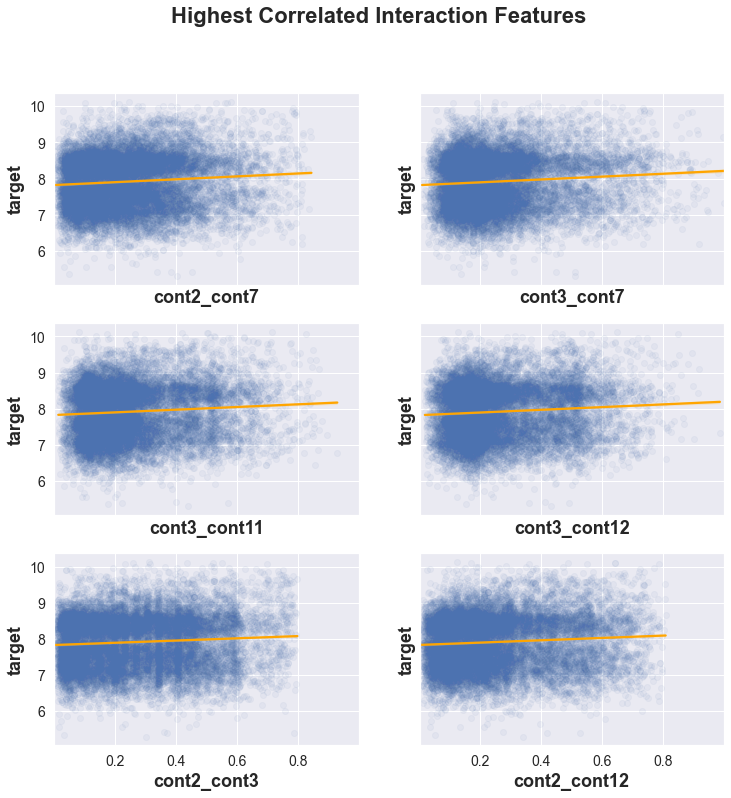

In [25]:

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols = 2, nrows = 3, 
                                                   sharex = True, sharey = True, 
                                                   figsize = (12,12))
sns.regplot(x = int1_corr.index[0], y = 'target', data = train_poly_sub, fit_reg = True, 
            line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.05}, 
            ax = ax1)
sns.regplot(x = int1_corr.index[1], y = 'target', data = train_poly_sub, fit_reg = True, 
            line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.05}, 
            ax = ax2)
sns.regplot(x = int1_corr.index[2], y = 'target', data = train_poly_sub, fit_reg = True, 
            line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.05}, 
            ax = ax3)
sns.regplot(x = int1_corr.index[3], y = 'target', data = train_poly_sub, fit_reg = True, 
            line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.05}, 
            ax = ax4)
sns.regplot(x = int1_corr.index[4], y = 'target', data = train_poly_sub, fit_reg = True, 
            line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.05}, 
            ax = ax5)
sns.regplot(x = int1_corr.index[5], y = 'target', data = train_poly_sub, fit_reg = True, 
            line_kws = {'color' : 'orange'}, scatter_kws = {'alpha': 0.05}, 
            ax = ax6)

plt.suptitle('Highest Correlated Interaction Features')
;

Viewing the regression plots for the 6 strongest correlated features to the target illustrates the weak relationship of even these new features to the target.

### Bivariate Additive Features

In [26]:
train_add = train.copy()

for feat in features:
    for feat2 in features:
        if feat[4:] < feat2[4:]:
            train_add[feat + '-' + feat2] = train_add[feat] + train_add[feat2]

corr_add = train_add.corr()[['target']].drop('target')    
corr_add.sort_values('target', inplace = True)

''

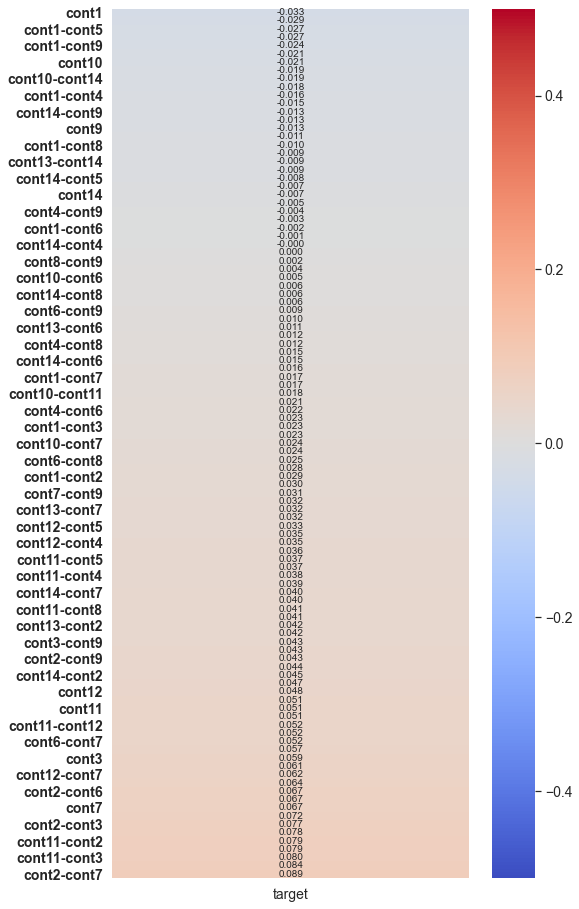

In [27]:
plt.figure(figsize = (8, 16))
sns.heatmap(corr_add,
            annot = True,
            cmap = 'coolwarm',
            vmin = -0.5, 
            vmax = 0.5,
            fmt = '.3f', 
            annot_kws = {'fontsize' : 10})
plt.yticks(fontweight = 'bold', rotation = 0)
;

### Bivariate Ratio Features

In [28]:
train_rat = train.copy()

for feat in features:
    for feat2 in features:
        if feat[4:] < feat2[4:]:
            train_rat[feat + '-' + feat2] = train_rat[feat]/train_rat[feat2]

corr_rat = train_rat.corr()[['target']].drop('target')    
corr_rat.sort_values('target', inplace = True)

''

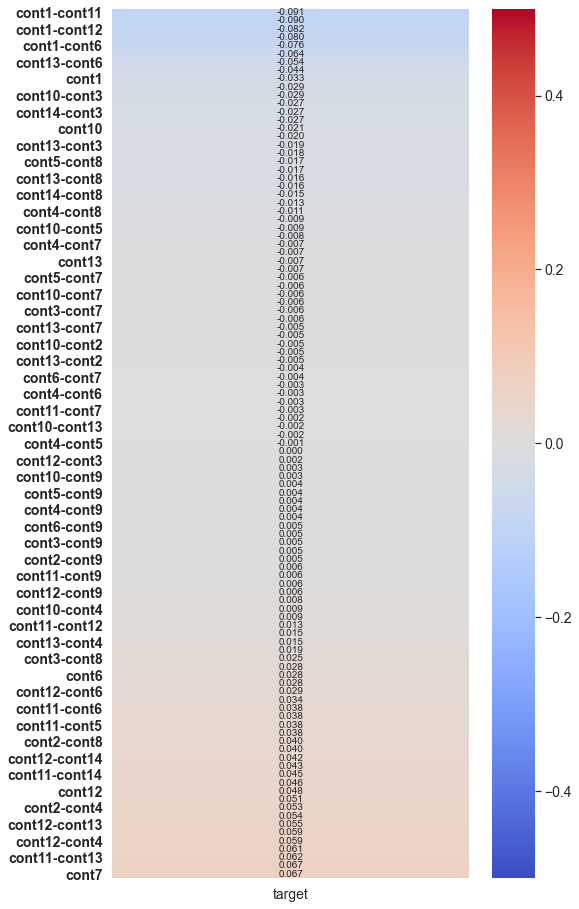

In [29]:
plt.figure(figsize = (8, 16))
sns.heatmap(corr_rat,
            annot = True,
            cmap = 'coolwarm',
            vmin = -0.5, 
            vmax = 0.5,
            fmt = '.3f', 
            annot_kws = {'fontsize' : 10})
plt.yticks(fontweight = 'bold', rotation = 0)
;